![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_2/practica_5/practica_5.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

# **Pŕactica No. 5**
## **Detección de Anomalias**

## **Objetivos**
- Hacer uso del Autoencoder como Arquitectura de detección de anomalías.
- Usar **Custom Models** de Tensorflow para construir el Autoencoder.
- Introducción a Callbacks en Keras.

## **Problema**
- Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

In [1]:
%%shell
pip install --progress-bar off -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install --progress-bar off -q tqdm==4.56.0
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py










ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.

shred: setup_colab_general.py: failed to open for writing: No such file or directory


## **Importando las librerías necesarias para el laboratorio**

In [2]:
import numpy as np
import pandas as pd

import os

import setup_colab_general as setup_general
setup_general.setup_general()

from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import utils.general as gen

import pandas_profiling

from sklearn.model_selection import StratifiedShuffleSplit

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [3]:
data_id = "1gS-GG4ThA2-HnVlK5eDI1I7-7aLlPg5N"

In [4]:
gen.download_file_from_google_drive(data_id, "creditcard.csv.gz")

0KB [00:00, ?KB/s]

## **Perfilamiento y Lectura**

In [5]:
card_data = pd.read_csv("data/creditcard.csv.gz")

In [6]:
card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
X = card_data.drop(columns=["Class"])
y = card_data["Class"]

In [8]:
X.shape, y.shape

((284807, 30), (284807,))

In [9]:
y.mean() * 100, (1 - y.mean()) * 100

(0.1727485630620034, 99.82725143693798)

In [10]:
timedelta = pd.to_timedelta(X["Time"], unit="s")

X["Time_min"] = (timedelta.dt.components.minutes).astype(int)
X["Time_hour"] = (timedelta.dt.components.hours).astype(int)
X.drop(columns=["Time"], inplace=True)

In [ ]:
pandas_profiling.ProfileReport(X, minimal=True, dark_mode=True)

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## **Procesamiento y Visualización**
- En esta ocasión, vamos a ver la distribución de cada variable de nuestro dataset con incidencias normales y fraudulentas. Para aquellas variables que tengan una distribución parecida entre sus dos incidencias, se les eliminará de los datos.

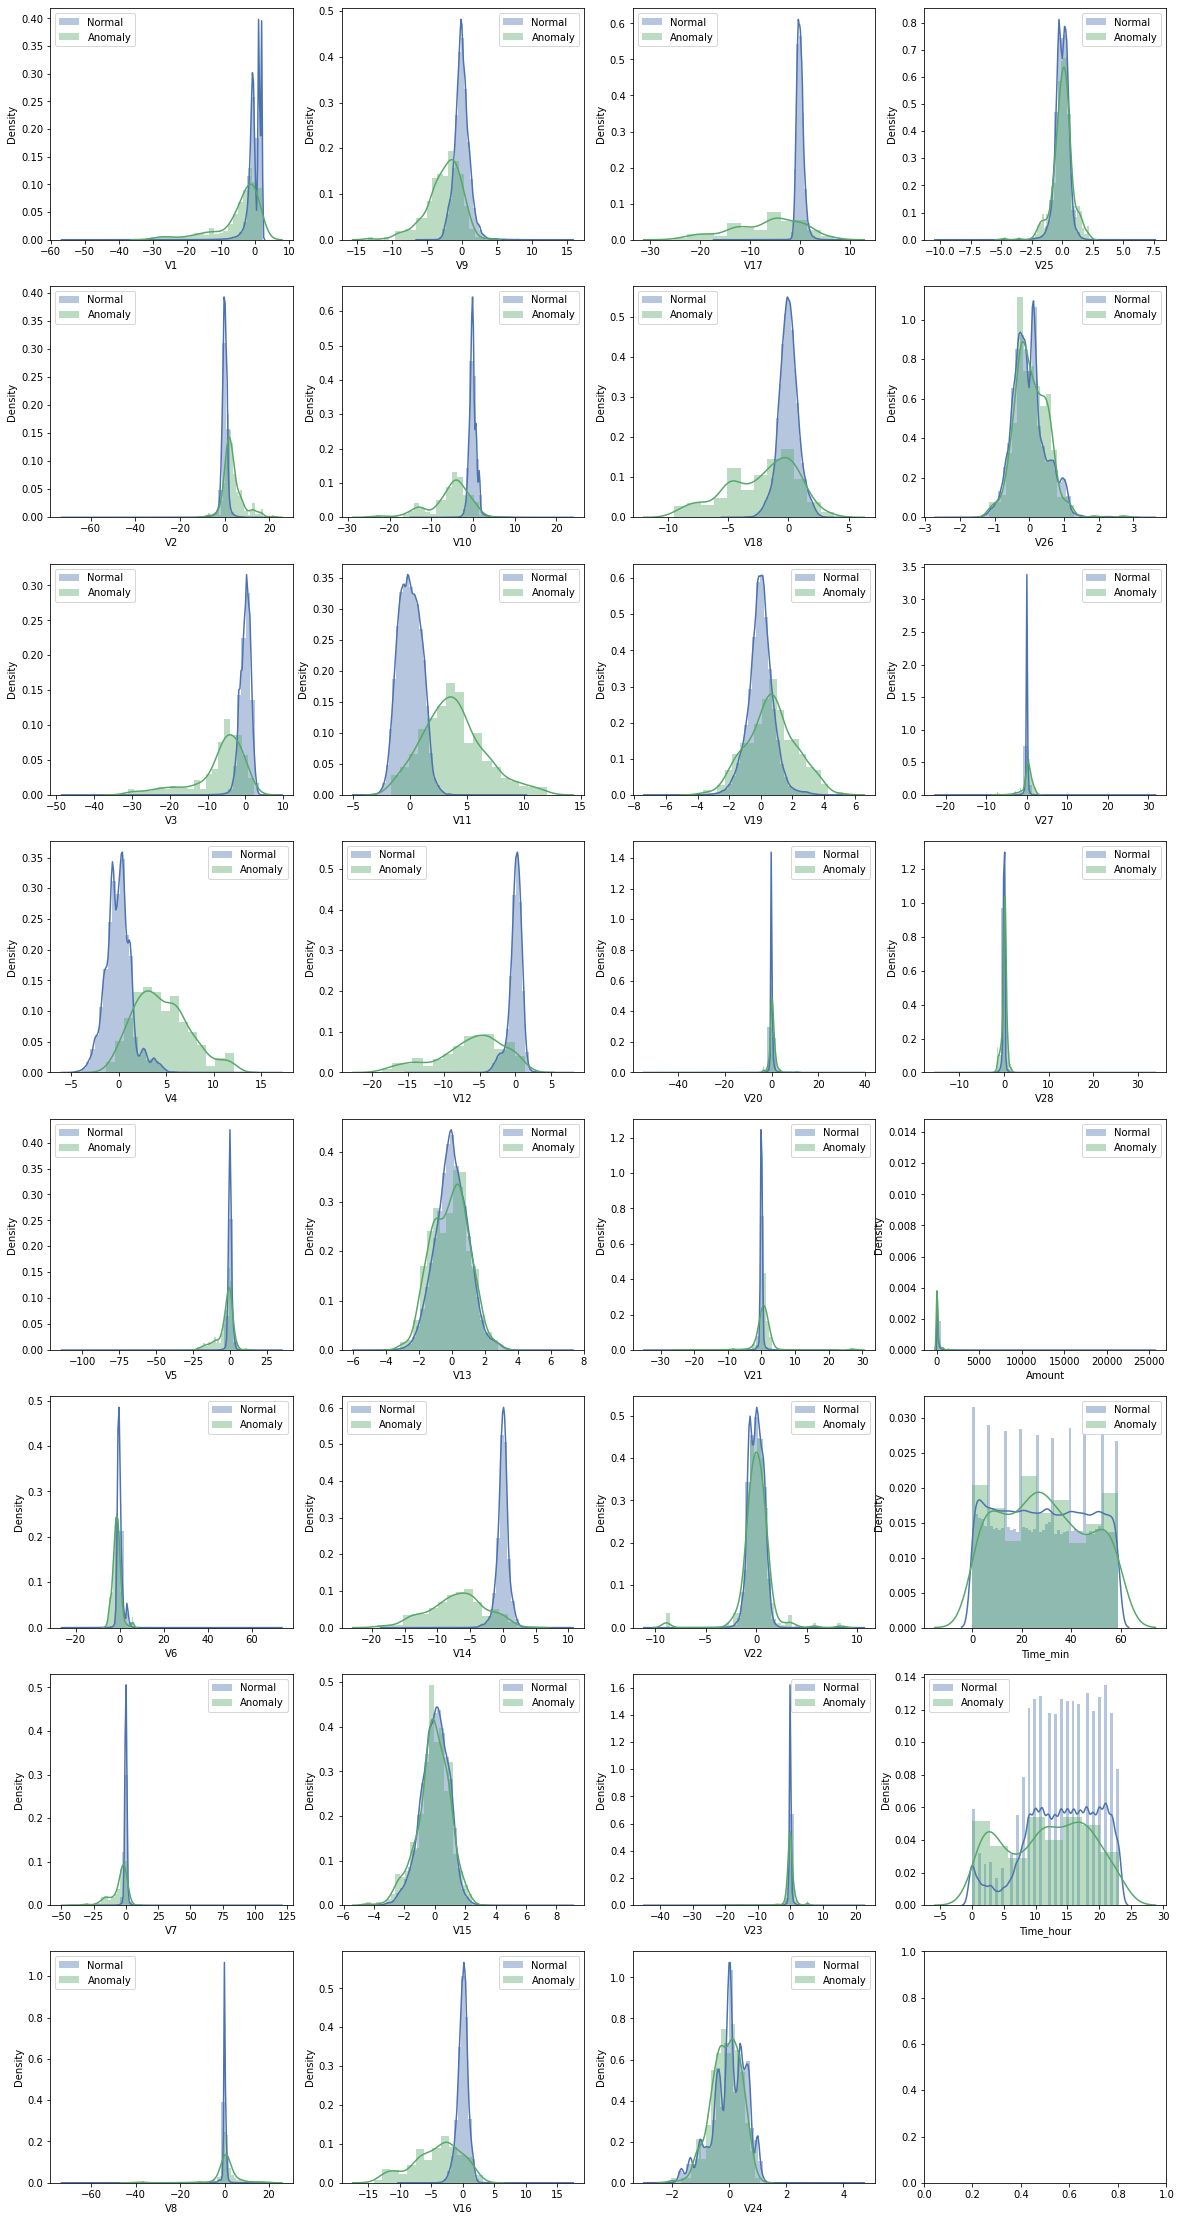

In [ ]:
fig, ax = plt.subplots(8, 4, figsize=(5 * 4, 5 * 8))

count = 0

for idx, (col_name, col_data) in enumerate(X.iteritems()):
    
    sns.distplot(col_data[y==0], ax=ax[idx % 8][count], label="Normal")
    sns.distplot(col_data[y==1], ax=ax[idx % 8][count], label="Anomaly")
    ax[idx % 8][count].legend(loc="best")

    if (idx + 1) % 8 == 0:
        count += 1

In [11]:
columns_to_drop = [
    "V25", "V26", "V15", "V22", 
    "Time_min", "Time_hour", "V24", "V28"
]

In [12]:
X.drop(columns=columns_to_drop, inplace=True)

In [13]:
splitter = StratifiedShuffleSplit(test_size=0.2, random_state=1234)

In [14]:
X, y = X.values, y.values

In [15]:
for train_index, test_index in splitter.split(X, y):
    full_X_train, full_y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

In [16]:
for train_index, val_index in splitter.split(full_X_train, full_y_train):
    X_train, y_train = full_X_train[train_index], full_y_train[train_index]
    X_val, y_val = full_X_train[val_index], full_y_train[val_index]

## **Modelamiento**

In [ ]:
keras.Model?

In [17]:
class Autoencoder(keras.Model):
    def __init__(self, n_out: int):
        super(Autoencoder, self).__init__()

        self.encoder = keras.Sequential([
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(16, activation="relu"),
            keras.layers.Dense(8, activation="relu"),
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(16, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(n_out),
        ])

    def call(
        self, inputs: tf.Tensor
    ) -> tf.Tensor:
        inputs = self.encoder(inputs)
        return self.decoder(inputs)

In [18]:
model = Autoencoder(X.shape[-1])

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min"
)

model.compile(loss="mse", optimizer="adam")

In [45]:
history = model.fit(
    X_train[y_train==0], X_train[y_train==0],
    validation_data=(X_val[y_val==0], X_val[y_val==0]),
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
5687/5687 [==============================] - 18s 3ms/step - loss: 5.3153 - val_loss: 0.8325
Epoch 2/20
5687/5687 [==============================] - 15s 3ms/step - loss: 3.2358 - val_loss: 0.6976
Epoch 3/20
5687/5687 [==============================] - 15s 3ms/step - loss: 4.7655 - val_loss: 5.8373
Epoch 4/20
5687/5687 [==============================] - 16s 3ms/step - loss: 9.4656 - val_loss: 0.5853
Epoch 5/20
5687/5687 [==============================] - 14s 2ms/step - loss: 6.8900 - val_loss: 0.5513
Epoch 6/20
5687/5687 [==============================] - 20s 4ms/step - loss: 5.6747 - val_loss: 0.5131
Epoch 7/20
5687/5687 [==============================] - 15s 3ms/step - loss: 3.4933 - val_loss: 0.4610
Epoch 8/20
5687/5687 [==============================] - 14s 2ms/step - loss: 3.1807 - val_loss: 10.7334
Epoch 9/20
5687/5687 [==============================] - 14s 2ms/step - loss: 3.2479 - val_loss: 13.3003
Epoch 10/20
5687/5687 [==============================] - 16s 3ms/step -

## **Validación y Análisis de Resultados**

In [52]:
encoder_out = model.encoder(
    X_test[y_test==0][0].reshape(-1, X_test.shape[-1])
)
decoder_out = model.decoder(encoder_out)

In [53]:
encoder_out.shape

TensorShape([1, 8])

In [54]:
decoder_out.shape

TensorShape([1, 23])

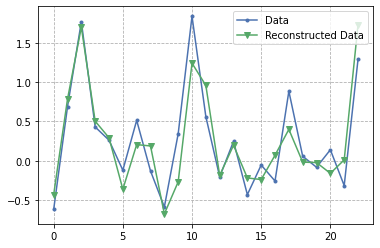

In [55]:
plt.plot(X_test[y_test==0][0], ".-", label="Data")
plt.plot(decoder_out[0], "v-", label="Reconstructed Data")
plt.legend(loc="best")
plt.grid(linestyle="--")
plt.show()

In [56]:
normal_reconstructions = model.predict(X_test[y_test==0])

normal_loss = tf.keras.losses.mae(
    normal_reconstructions, X_test[y_test==0]
)

In [57]:
X_test[y_test==0].shape

(56864, 23)

In [58]:
normal_loss.shape

TensorShape([56864])

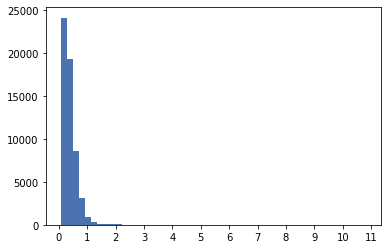

In [76]:
plt.hist(normal_loss, bins=50)
plt.xticks(range(12))
plt.show()

In [60]:
np.mean(normal_loss)

0.39304787846349787

In [61]:
np.std(normal_loss)

0.2697758512582924

In [66]:
thresh = np.mean(normal_loss) + np.std(normal_loss)

In [67]:
thresh

0.6628237297217903

In [68]:
anomaly_reconstructions = model.predict(X_test[y_test==1])

anomaly_loss = tf.keras.losses.mae(
    anomaly_reconstructions, X_test[y_test==1]
)

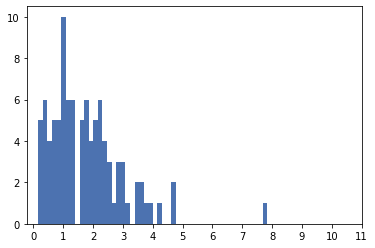

In [79]:
plt.hist(anomaly_loss, bins=50)
plt.xticks(range(12))
plt.show()

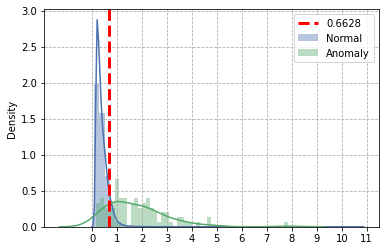

In [80]:
sns.distplot(normal_loss, bins=50, label="Normal")
sns.distplot(anomaly_loss, bins=50, label="Anomaly")
plt.axvline(
    thresh, color="r", linewidth=3, 
    linestyle="--", label=f"{thresh:.4f}"
)
plt.legend(loc="best")
plt.xticks(range(12))
plt.grid(linestyle="--")
plt.show()